In [2]:
%load_ext autoreload

In [4]:
%autoreload 2

import os
import sys
import json
import gc

import pickle 


from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution, filter_sort_index, gaussian, tie_kept_rank, orthogonalize


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

sys.path.append("../")
from src.model import MLModel, LightGBMModel
# from src.validation import plot_validation

# Config

In [5]:
class cfg:
    exp = "exp002"
    dataset_path = "../dataset/v5.0"
    feature_set = "small"
    
    model_params = {
        "objective": "regression",
        "metric": "l2",
        "n_estimators": 2000,
        "max_depth": 5,
        "learning_rate": 0.01,
        "feature_fraction": 0.1,
        "seed": 42,
    }
    
os.makedirs(cfg.exp, exist_ok=True)

# 辞書形式に変換して保存 (推論時に使用する)
# TODO: 特徴量もこの中に入れる
cfg_dict = {attr: getattr(cfg, attr) for attr in dir(cfg) if not attr.startswith("__") and not callable(getattr(cfg, attr))}
config_file = os.path.join(cfg.exp, "training_config.json")
with open(config_file, "w") as f:
    json.dump(cfg_dict, f, indent=4)


In [6]:
with open(f"{cfg.dataset_path}/features.json", "r") as f:
    feature_metadata = json.load(f)

# print(feature_metadata.keys())
feature_sets = feature_metadata["feature_sets"]
# print(feature_sets.keys())
feature_set = feature_sets[cfg.feature_set]
print(f"feature col length: {len(feature_set)}")

feature col length: 42


# Load Data

In [7]:
train = pd.read_parquet(
    f"{cfg.dataset_path}/train.parquet",
    columns=["era", "target"] + feature_set
)


print(train.shape)
display(train.head(2))


valid = pd.read_parquet(
    f"{cfg.dataset_path}/validation.parquet",
    columns=["era", "target"] + feature_set
)
print(valid.shape)
display(valid.head(2))

(2746270, 44)


,era,target,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,...,feature_tridactyl_immoral_snorting,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,0.25,2,2,2,2,2,0,1,2,...,4,1,1,3,0,2,2,3,3,2
n003bba8a98662e4,0001,0.25,2,2,2,2,2,1,4,2,...,4,2,0,0,0,2,2,4,4,2


(3565569, 44)


,era,target,feature_antistrophic_striate_conscriptionist,feature_bicameral_showery_wallaba,feature_bridal_fingered_pensioner,feature_collectivist_flaxen_gueux,feature_concurring_fabled_adapter,feature_crosscut_whilom_ataxy,feature_departmental_inimitable_sentencer,feature_dialectal_homely_cambodia,...,feature_tridactyl_immoral_snorting,feature_trimeter_soggy_greatest,feature_unanalyzable_excusable_whirlwind,feature_unbreakable_constraining_hegelianism,feature_unformed_bent_smatch,feature_unministerial_unextenuated_teleostean,feature_unmodish_zymogenic_rousing,feature_unsystematized_subcardinal_malaysia,feature_willful_sere_chronobiology,feature_zoological_peristomial_scute
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,0.75,0,2,1,2,2,1,1,2,...,1,2,3,0,2,2,1,3,2,0
n001e1318d5072ac,0575,0.00,1,1,3,2,1,3,3,4,...,2,4,3,2,2,3,1,1,0,1


# Preprocess

In [8]:
# target が 20 日、 era が週次なので重複してる。ので era を間引く
train["era_int"] = train["era"].astype(int)
valid["era_int"] = valid["era"].astype(int)

cond_train = train["era_int"] % 4 == 0
cond_valid = valid["era_int"] % 4 == 0

train = train.loc[cond_train]
# valid = valid.loc[cond_valid]

# Training

In [9]:
features = feature_set

In [10]:
model = LightGBMModel(
    model_params=cfg.model_params,
)
model.train(
    train[features],
    train["target"],
    eval_set=(valid[feature_set], valid["target"]),
    early_stopping_rounds=10
)

model.save_model(os.path.join(cfg.exp, "model.pkl"))

with open(os.path.join(cfg.exp, "feature.pkl"), "wb") as f:
     pickle.dump(features, f)

        
del train; gc.collect()

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 684735, number of used features: 42
[LightGBM] [Warning] Provided parameters cons

290

# Validation

In [11]:
valid_pred = model.predict(valid[features])
valid["pred"] = valid_pred

valid = valid[["era", "pred", "target"]]

In [12]:
plot_validation(cfg.dataset_path, valid)

NameError: name 'plot_validation' is not defined

In [ ]:
benchmark_models_path = os.path.join(cfg.dataset_path, "validation_benchmark_models.parquet")
bmc = pd.read_parquet(benchmark_models_path, columns=["era", "v5_lgbm_cyrusd20"])
bmc["v5_lgbm_cyrusd20"] = bmc["v5_lgbm_cyrusd20"].astype(np.float32)

print(bmc.shape)
print(bmc.info())

meta_model_path = os.path.join(cfg.dataset_path, "meta_model.parquet")
meta_model = pd.read_parquet(meta_model_path)
print(meta_model.shape)
print(meta_model.info())

valid = valid.reset_index().merge(
    meta_model.reset_index(),
    how="left",
    on=["era", "id"]
).merge(
    bmc.reset_index(),
    how="left",
    on=["era", "id"]
).set_index("id")

del bmc, meta_model

display(valid.head()) 

print(valid.shape)


<AxesSubplot: title={'center': 'Validation CORR'}, xlabel='era'>

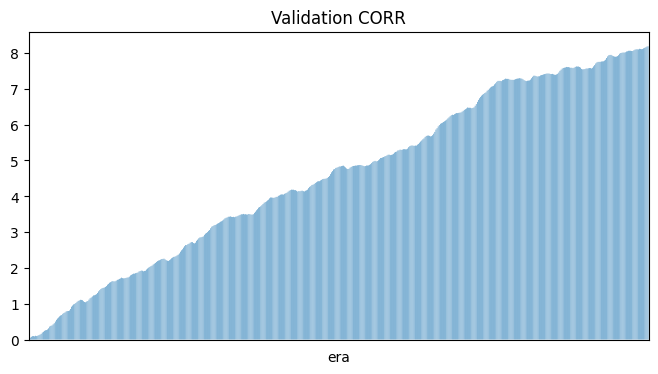

In [11]:

per_era_corr = valid[["era", "pred", "target"]].dropna().groupby("era").apply(
    lambda x: numerai_corr(x[["pred"]].dropna(), x["target"].dropna())
)
# Plot the per-era correlation
per_era_corr.cumsum().plot(
  title="Validation CORR",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)



<AxesSubplot: title={'center': 'Validation CORR'}, xlabel='era'>

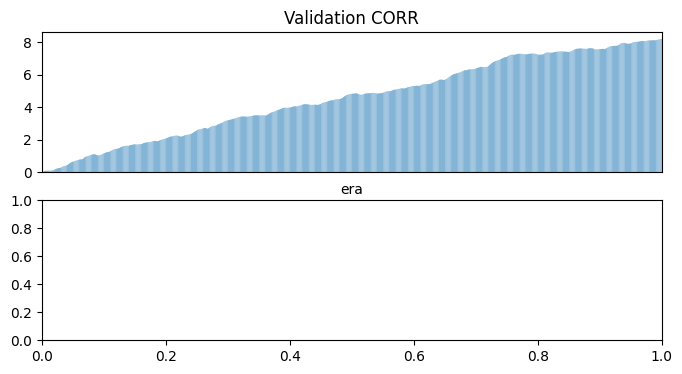

In [13]:
# Plot the per-era correlation

_, ax = plt.subplots(2, 1, figsize=(10, 5))
per_era_corr.cumsum().plot(
  title="Validation CORR",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False,
  ax=ax[0]
)



In [27]:
per_era_sharpe_ratio = per_era_corr["pred"].mean() / per_era_corr["pred"].std()
print(per_era_sharpe_ratio)

0.8679706674354761


<AxesSubplot: title={'center': 'Validation BMC'}, xlabel='era'>

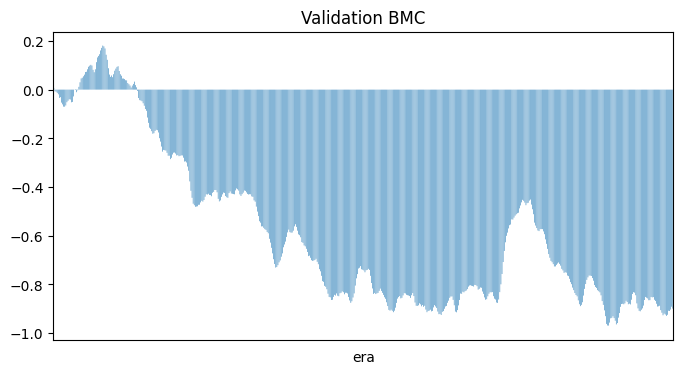

In [18]:

per_era_bmc = valid[["era", "target", "pred", "v5_lgbm_cyrusd20"]].dropna().groupby("era").apply(
    lambda x: correlation_contribution(x[["pred"]], x["v5_lgbm_cyrusd20"], x["target"])
)
# Plot the per-era correlation
per_era_bmc.cumsum().plot(
  title="Validation BMC",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)



<AxesSubplot: title={'center': 'Validation MMC'}, xlabel='era'>

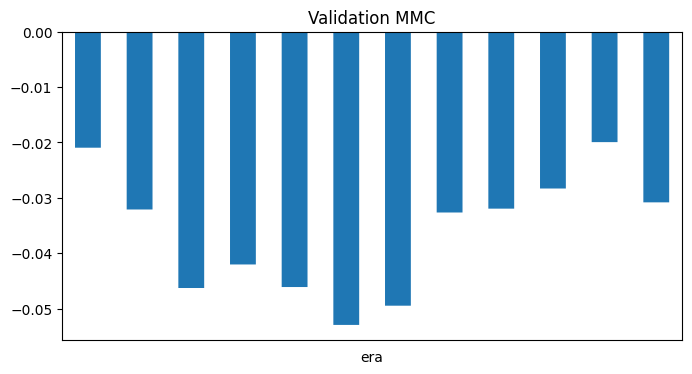

In [19]:

per_era_mmc = valid[["era", "target", "pred", "numerai_meta_model"]].dropna().groupby("era").apply(
    lambda x: correlation_contribution(x[["pred"]], x["numerai_meta_model"], x["target"])
)
# Plot the per-era correlation
per_era_mmc.cumsum().plot(
  title="Validation MMC",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)



In [20]:
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std()
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()
 
mmc_mean = per_era_mmc.mean()
mmc_std = per_era_mmc.std()
mmc_sharpe = mmc_mean / mmc_std
mmc_max_drawdown = (per_era_mmc.cumsum().expanding(min_periods=1).max() - per_era_mmc.cumsum()).max()

pd.DataFrame({
    "exp": [cfg.exp],
    "corr_mean": [corr_mean.values[0]],
    "corr_std": [corr_std.values[0]],
    "corr_shape": [corr_sharpe.values[0]],
    "corr_max_drawdown": [corr_max_drawdown.values[0]],
    
    "mmc_mean": [mmc_mean.values[0]],
    "mmc_std": [mmc_std.values[0]],
    "mmc_shape": [mmc_sharpe.values[0]],
    "mmc_max_drawdown": [mmc_max_drawdown.values[0]],
})

,exp,corr_mean,corr_std,corr_shape,corr_max_drawdown,mmc_mean,mmc_std,mmc_shape,mmc_max_drawdown
0,exp002,0.014365,0.01655,0.867968,0.092891,-0.002568,0.010718,-0.239635,0.031986


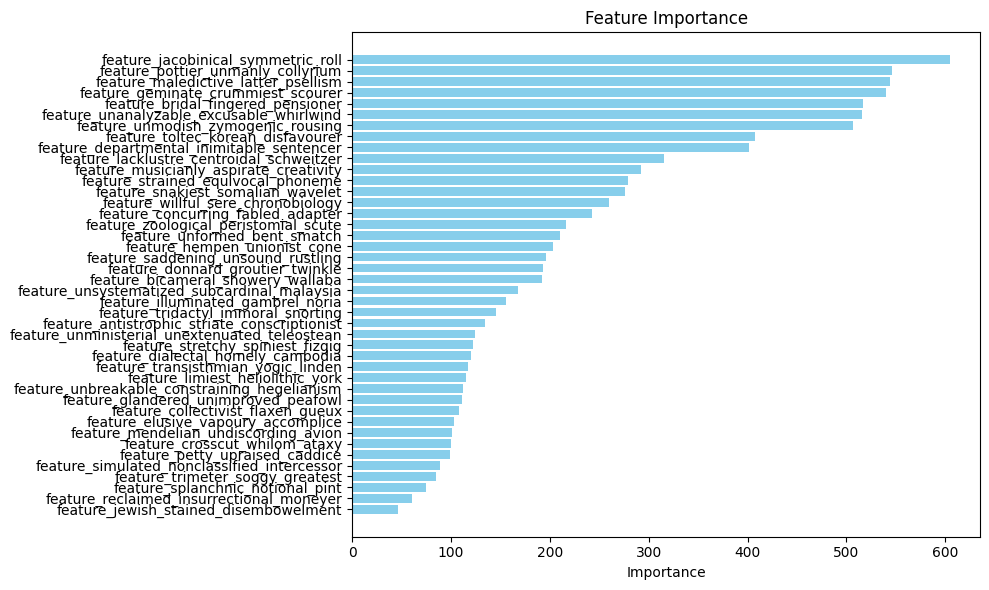

In [21]:
model.visualize_feature_importance(feature_names=feature_set, max_features=100)